In [ ]:
# Import statments
import pandas as pd
import re
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

In [ ]:


# Download latest version of dataset
path = kagglehub.dataset_download("ahmettyilmazz/fuel-consumption")

df1 = pd.read_csv(path + "/Fuel_Consumption_2000-2022.csv")

# Download latest version dataset 2
path = kagglehub.dataset_download("imtkaggleteam/fuel-concumption-ratings-2023")

df2 = pd.read_csv(path + "/Fuel Consumption Ratings 2023.csv", encoding='latin-1')

# removing columns at end that just describe each column
df2 = df2.head(833)


100%|██████████| 257k/257k [00:00<00:00, 430kB/s]

Extracting files...


100%|██████████| 12.9k/12.9k [00:00<00:00, 9.34MB/s]

Extracting files...


In [ ]:
#### Data pre proccesing

#normalize capitalization in the brand of car
df1['MAKE'] = df1['MAKE'].str.lower()
df2['Make'] = df2['Make'].str.lower()

#removing model type and just including drive type
for model in df1["MODEL"].items():
    if "AWD" in model[1]:
      df1.loc[model[0], "MODEL"] = "AWD"
    elif "4WD" in model[1] or "4X4" in model[1]:
      df1.loc[model[0], "MODEL"] = "4WD"
    else:
      df1.loc[model[0], "MODEL"] = "2WD"

for model in df2["Model"].items():
    if "AWD" in model[1]:
      df2.loc[model[0], "Model"] = "AWD"
    elif "4WD" in model[1] or "4X4" in model[1]:
      df2.loc[model[0], "Model"] = "4WD"
    else:
      df2.loc[model[0], "Model"] = "2WD"

# Vehicle class normilization

# make all lowercase
df1['VEHICLE CLASS'] = df1['VEHICLE CLASS'].str.lower()
df2['Vehicle Class'] = df2['Vehicle Class'].str.lower()

# normalize carius different vehicle class formats
for vclass in df1["VEHICLE CLASS"].items():
  if vclass[1] == "station wagon - mid-size":
    df1.loc[vclass[0], "VEHICLE CLASS"] = "station wagon: mid-size"
  elif vclass[1] == "station wagon - small":
    df1.loc[vclass[0], "VEHICLE CLASS"] = "station wagon: small"
  elif vclass[1] == "pickup truck - small":
    df1.loc[vclass[0], "VEHICLE CLASS"] = "pickup truck: small"
  elif vclass[1] == "pickup truck - standard":
    df1.loc[vclass[0], "VEHICLE CLASS"] = "pickup truck: standard"
  elif vclass[1] == "suv - standard":
    df1.loc[vclass[0], "VEHICLE CLASS"] = "suv: standard"
  elif vclass[1] == "suv - small":
    df1.loc[vclass[0], "VEHICLE CLASS"] = "suv: small"
  elif vclass[1] == "van - cargo":
    df1.loc[vclass[0], "VEHICLE CLASS"] = "van: cargo"
  elif vclass[1] == "van - passenger":
    df1.loc[vclass[0], "VEHICLE CLASS"] = "van: passenger"




# remove smog and COMB columns
df1.pop("COMB (L/100 km)")
df1.pop("COMB (mpg)")

df2.pop("Comb (L/100 km)")
df2.pop("Comb (mpg)")
df2.pop("Smog Rating")
df2.pop("CO2 Rating")

#normalize column names
df1.columns = df1.columns.str.lower()
df2.columns = df2.columns.str.lower()

df2.rename(columns={'engine size (l)': 'engine size', 'fuel type': 'fuel', 'fuel consumption (l/100km)': 'fuel consumption', 'co2 emissions (g/km)': 'emissions'}, inplace=True)

#normalize column data types
df2 = df2.astype({'year': int, 'cylinders': int, 'emissions': int})

In [ ]:
# combine datasets 1 and 2
df = pd.concat([df1, df2])
df

,year,make,model,vehicle class,engine size,cylinders,transmission,fuel,fuel consumption,hwy (l/100 km),emissions
0,2000,acura,2WD,compact,1.6,4,A4,X,9.2,6.7,186
1,2000,acura,2WD,compact,1.6,4,M5,X,8.5,6.5,175
2,2000,acura,2WD,mid-size,3.2,6,AS5,Z,12.2,7.4,230
3,2000,acura,2WD,mid-size,3.5,6,A4,Z,13.4,9.2,264
4,2000,acura,2WD,subcompact,1.8,4,A4,X,10.0,7.0,198
...,...,...,...,...,...,...,...,...,...,...,...
828,2023,volvo,AWD,suv: small,2.0,4,AS8,Z,10.2,7.9,215
829,2023,volvo,AWD,suv: small,2.0,4,AS8,Z,10.3,8.2,218
830,2023,volvo,AWD,suv: small,2.0,4,AS8,Z,11.1,8.7,233
831,2023,volvo,AWD,suv: standard,2.0,4,AS8,Z,10.5,8.4,223


In [ ]:
# Make fuel type values more user friendly
for fuels in df["fuel"].items():
  if fuels[1] == "X":
    df.loc[fuels[0], "fuel"] = "gasoline"
  elif fuels[1] == "Z":
    df.loc[fuels[0], "fuel"] = "premium gasoline"
  elif fuels[1] == "D":
    df.loc[fuels[0], "fuel"] = "diesel"
  elif fuels[1] == "E":
    df.loc[fuels[0], "fuel"] = "ethanol"
  elif fuels[1] == "N":
    df.loc[fuels[0], "fuel"] = "natural gas"

In [ ]:
# String spliting function (takes a string and splits it into letters and numbers)
def split_string(s):
    match = re.match(r"([A-Z]+)(\d+)", s)
    if match:
        return match.groups()

In [ ]:
# Split transmission column into 2 columns
# Example: combined  --> transmission type + gear count
# Example: (A5)      --> (A)               + (5)

transmissions = df["transmission"]
transmission_types = []
gears = []

# Iterate through all combined transmission values and
for transmission in transmissions:

# Check if it is an Continuously Variable Transmission (AV) and set the gear count to 20
  if transmission == "AV":
    transmission_types.append("AV")
    gears.append(20)

# Split transmission into the different columns of type and gear count
  else:
    split = split_string(transmission)
    transmission_types.append(split[0])
    gears.append(int(split[1]))

# Remove old transmission column and insert the 2 new sepperated columns
df.pop("transmission")
df.insert(6, "transmission type", transmission_types)
df.insert(7, "gears", gears)

In [ ]:
# Vehicle class splitting into 2 columns (SUV:mid-size)combined --> (SUV)class + (mid-size)size
# Example: combined       --> class + size
# Example: (SUV:mid-size) --> (SUV) + (mid-size)

vehicle_class = df["vehicle class"]
vehicle = []
size = []

# Iterate through the vehicle class combined column
for vehicleClass in vehicle_class:

  # If the combined vlaue has 2 parts (some have only 1)
  if ":" in vehicleClass:
    # Split combined value into the 2 seperated values
    split = vehicleClass.split(": ")
    vehicle.append(split[0])
    size.append(split[1])

# Conditionals for different sizes

# Compact class has sub classes sub and mini (compact class never has a second part in the data sets)
  elif "compact" in vehicleClass:
    # Triggered if vehicle class is "subcompact"
    if "sub" in vehicleClass:
      vehicle.append("compact")
      size.append("sub")
    # Triggered if vehicle class is "minicompact"
    elif "mini" in vehicleClass:
      vehicle.append("compact")
      size.append("mini")
    # Triggered if vehicle class is "compact"
    else:
      vehicle.append("compact")
      size.append("small")

  elif "mid-size" in vehicleClass:
    vehicle.append("mid-size")
    size.append("mid-size")

  elif "full-size" in vehicleClass:
    vehicle.append("full-size")
    size.append("full-size")

  elif "two-seater" in vehicleClass:
    vehicle.append("two-seater")
    size.append("mini")

  elif "minivan" in vehicleClass:
    vehicle.append("minivan")
    size.append("full-size")

  elif "suv" in vehicleClass:
    vehicle.append("suv")
    size.append("standard")

  elif "special purpose vehicle" in vehicleClass:
    vehicle.append("special purpose vehicle")
    size.append("massive")


# Remove combined vehicle class column and insert the 2 new sepperated columns
df.pop("vehicle class")
df.insert(3, "vehicle", vehicle)
df.insert(4, "size", size)

In [ ]:
# Encoding

# Label encoding certain columns
# Import label encoder
label_encoder = preprocessing.LabelEncoder()

# Label encode function
def LabelEncode(column, order):
  label_encoder.fit(df[column])
  label_encoder.classes_ = np.array(order)
  df[column] = label_encoder.transform(df[column])
  # Preview label encoded order
  print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Labe lencode ordered columns
LabelEncode('model', ['2WD', 'AWD', '4WD'])
LabelEncode("size", ['mini', 'sub', 'small', 'mid-size', 'standard', 'full-size', 'passenger', 'cargo', 'massive'])
LabelEncode("fuel", ['diesel', 'premium gasoline', 'gasoline', 'ethanol', 'natural gas'])



# Onehot encode the rest
df = pd.get_dummies(df)


{np.str_('2WD'): np.int64(0), np.str_('AWD'): np.int64(1), np.str_('4WD'): np.int64(2)}
{np.str_('mini'): np.int64(0), np.str_('sub'): np.int64(1), np.str_('small'): np.int64(2), np.str_('mid-size'): np.int64(3), np.str_('standard'): np.int64(4), np.str_('full-size'): np.int64(5), np.str_('passenger'): np.int64(6), np.str_('cargo'): np.int64(7), np.str_('massive'): np.int64(8)}
{np.str_('diesel'): np.int64(0), np.str_('premium gasoline'): np.int64(1), np.str_('gasoline'): np.int64(2), np.str_('ethanol'): np.int64(3), np.str_('natural gas'): np.int64(4)}


In [ ]:
# Heatmap generation - disabled due to performance issues (re-enable if needed)
#corrm = df.corr()
#plt.figure(figsize=(50,50))
#sns.heatmap(corrm, annot = False , linewidths = 0.1)

In [ ]:
# Import sklearn needed components
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Taking the data set and making into inputs and labels

# Remove the correct values from input data
X = df.drop(columns=['fuel consumption','hwy (l/100 km)', 'emissions'])

# Take just the correct values
y = df[['fuel consumption','hwy (l/100 km)', 'emissions']]

y1 = df[['fuel consumption']]
y2 = df[['hwy (l/100 km)']]
y3 = df[['emissions']]

# Split input data and correct values into a 80 20 split of training and testing data
X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=10)

In [ ]:
# Initiate Random forest reggresor model
clf = RandomForestRegressor()

# Fit the model to the training data
clf.fit(X_train, y_train)

# Save the model after fitting as a file
with open("RFR_model.pkl", "wb") as f:
  pickle.dump(clf, f)

# Predict labels of test values and test for accuracy
predictions = clf.predict(X_test)
predictions.reshape(1, -1)

# Outdated acuracy score prediction code
## accuracy_score(predictions, y_test)


# Calculates the mean square error of the model. The lower the value the better
mse = mean_squared_error(y_test, predictions)
print("mean squared error:" + str(mse))

# Calculates the r2_score of the model. closer to 1 the better
R2score = r2_score(y_test, predictions)
print("r2 score:" + str(R2score))


mean squared error:48.19338983008379
r2 score:0.9583670067898812


In [ ]:
# Reorginize predictions
Rfuel_predictions = []
HWfuel_predictions = []
emissions_predictions = []

# Iterating through predictions and seperating each output to a different list
for prediction in predictions:
  Rfuel = prediction[0]
  HWfuel = prediction[1]
  emissions = prediction[2]
  Rfuel_predictions.append(Rfuel)
  HWfuel_predictions.append(HWfuel)
  emissions_predictions.append(emissions)

# Creating one list including all the predictions
predictions = [Rfuel_predictions, HWfuel_predictions, emissions_predictions]

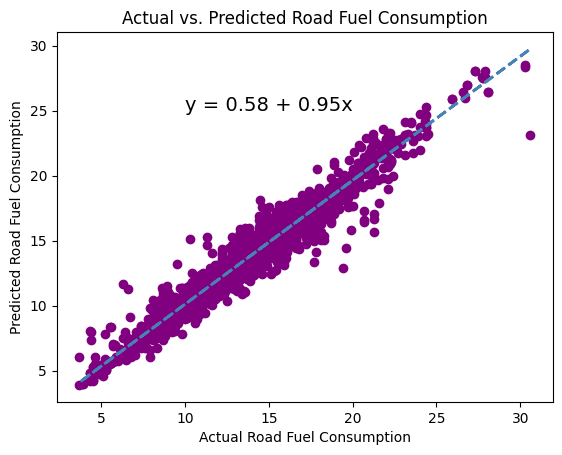

In [ ]:
# Scatter plot of the predictions vs label
# Road fuel efficiency
a, b = np.polyfit(y_test['fuel consumption'], predictions[0], 1)
plt.scatter(y_test['fuel consumption'], predictions[0], color='purple')
plt.plot(y_test['fuel consumption'], a*y_test['fuel consumption'] + b, color='steelblue', linestyle='--', linewidth=2)  # Line of best fit
plt.xlabel("Actual Road Fuel Consumption")
plt.ylabel("Predicted Road Fuel Consumption")
plt.title("Actual vs. Predicted Road Fuel Consumption")
plt.text(10, 25, 'y = {:.2f} + {:.2f}x'.format(b, a), size=14)
plt.show()

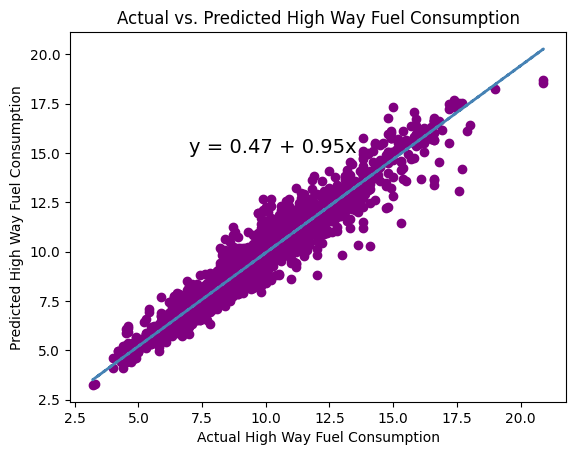

In [ ]:
# Highway Road efficiency
a, b = np.polyfit(y_test['hwy (l/100 km)'], predictions[1], 1)
plt.scatter(y_test['hwy (l/100 km)'], predictions[1], color='purple')
plt.plot(y_test['hwy (l/100 km)'], a*y_test['hwy (l/100 km)'] + b, color='steelblue', linestyle='--', linewidth=2)  # Line of best fit
plt.xlabel("Actual High Way Fuel Consumption")
plt.ylabel("Predicted High Way Fuel Consumption")
plt.title("Actual vs. Predicted High Way Fuel Consumption")
plt.text(7, 15, 'y = {:.2f} + {:.2f}x'.format(b, a), size=14)
plt.show()

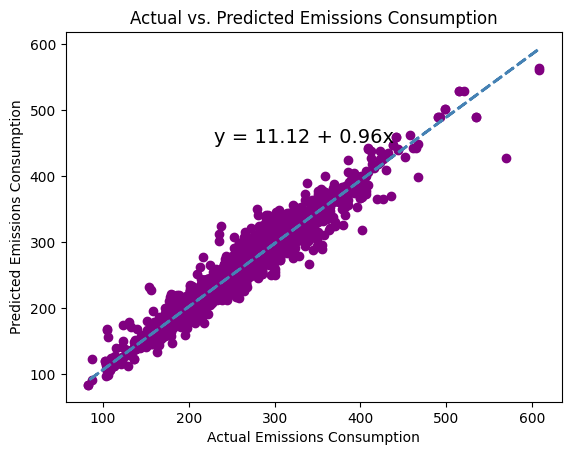

In [ ]:
# Emmisions
a, b = np.polyfit(y_test['emissions'], predictions[2], 1)
plt.scatter(y_test['emissions'], predictions[2], color='purple')
plt.plot(y_test['emissions'], a*y_test['emissions'] + b, color='steelblue', linestyle='--', linewidth=2)  # Line of best fit
plt.xlabel("Actual Emissions Consumption")
plt.ylabel("Predicted Emissions Consumption")
plt.title("Actual vs. Predicted Emissions Consumption")
plt.text(230, 450, 'y = {:.2f} + {:.2f}x'.format(b, a), size=14)
plt.show()

In [ ]:
# Imports for NN
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Preproccesing for NN

# Train test split for individual correct values
X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(
    X, y1, y2, y3, test_size=0.2, shuffle=True)


In [ ]:
# Define model 1
# 3 models for the 3 outputs
model1 = keras.Sequential([
    keras.layers.Input(shape=(74,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation=None)
])

# Define model 2
model2 = keras.Sequential([
    keras.layers.Input(shape=(74,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation=None)
])

# Define model 3
model3 = keras.Sequential([
    keras.layers.Input(shape=(74,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation=None)
])

In [ ]:
# Compile each model
model1.compile(optimizer='adam',
              loss='mae',
              metrics=['mean_absolute_error'])

model2.compile(optimizer='adam',
              loss='mae',
              metrics=['mean_absolute_error'])

model3.compile(optimizer='adam',
              loss='mae',
              metrics=['mean_absolute_error'])

In [ ]:
# Train each model
history1 = model1.fit(X_train, y1_train, epochs=30, batch_size=64, validation_data=(X_test, y1_test))

history2 = model2.fit(X_train, y2_train, epochs=30, batch_size=64, validation_data=(X_test, y2_test))

history3 = model3.fit(X_train, y3_train, epochs=30, batch_size=64, validation_data=(X_test, y3_test))

Epoch 1/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 2.9127 - mean_absolute_error: 2.9127 - val_loss: 3.7015 - val_mean_absolute_error: 3.7015
Epoch 2/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 1.4242 - mean_absolute_error: 1.4242 - val_loss: 1.1345 - val_mean_absolute_error: 1.1345
Epoch 3/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.2918 - mean_absolute_error: 1.2918 - val_loss: 1.2359 - val_mean_absolute_error: 1.2359
Epoch 4/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.1975 - mean_absolute_error: 1.1975 - val_loss: 2.0981 - val_mean_absolute_error: 2.0981
Epoch 5/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.2189 - mean_absolute_error: 1.2189 - val_loss: 1.2688 - val_mean_absolute_error: 1.2688
Epoch 6/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.0929 - mean_absolute_error: 1.0929 - val_loss: 1.0726 - val_mean_absolute_error: 1.0726
Epoch 7/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.0772 - mean_absolute_error: 1.0

In [ ]:
######## ---- disabled due to different backup format used ----

# Link drive for storage - disabled
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Save model to google drive - disabled
#try:
#  model1 = keras.models.load_model('drive/MyDrive/fuel_project/model1.keras')
#  model2 = keras.models.load_model('drive/MyDrive/fuel_project/model2.keras')
#  model3 = keras.models.load_model('drive/MyDrive/fuel_project/model3.keras')
#except:
#  model1.save('drive/MyDrive/fuel_project/model1.keras')
#  model2.save('drive/MyDrive/fuel_project/model2.keras')
#  model3.save('drive/MyDrive/fuel_project/model3.keras')

In [ ]:
# Save models via pickle to bin file
with open("NN_model1.pkl", "wb") as f:
  pickle.dump(model1, f)

with open("NN_model2.pkl", "wb") as f:
  pickle.dump(model2, f)

with open("NN_model3.pkl", "wb") as f:
  pickle.dump(model3, f)

In [ ]:
# Testing each model for loss and accuracy
test_loss, test_acc = model1.evaluate(X_test, y1_test)

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6407 - mean_absolute_error: 0.6407


In [ ]:
test_loss, test_acc = model2.evaluate(X_test, y2_test)

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4887 - mean_absolute_error: 0.4887


In [ ]:
test_loss, test_acc = model3.evaluate(X_test, y3_test)

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.6414 - mean_absolute_error: 12.6414


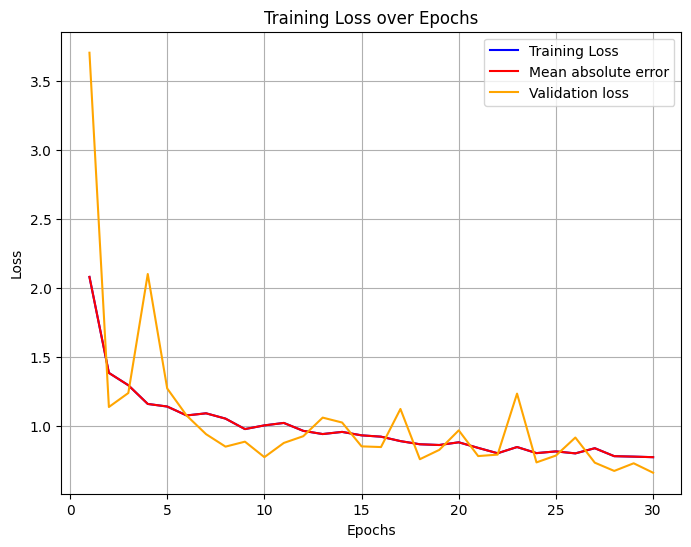

In [ ]:
# Plotting loss curves for each model
# Extract loss values
loss_values1 = history1.history['loss']
mae_values1 = history1.history['mean_absolute_error']
validation_loss1 = history1.history['val_loss']
epochs = range(1, len(loss_values1) + 1)

# Plot loss curve
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values1, label='Training Loss', color='blue', linestyle='-')
plt.plot(epochs, mae_values1, label='Mean absolute error', color='red', linestyle='-')
plt.plot(epochs, validation_loss1, label='Validation loss', color='orange', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

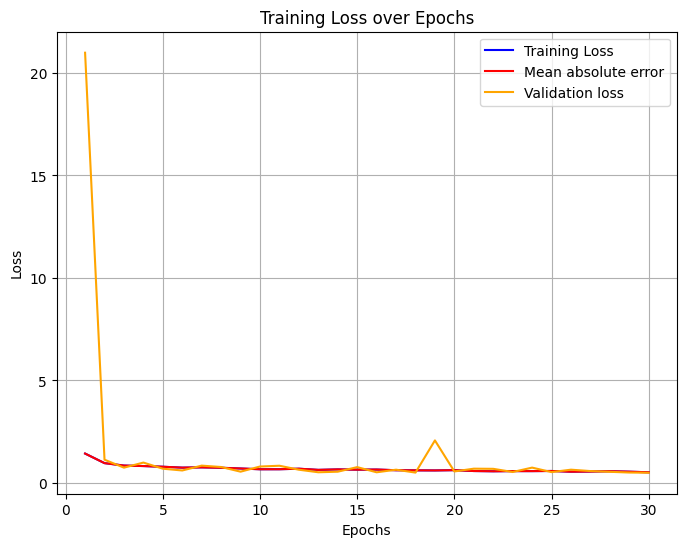

In [ ]:
# Extract loss values
loss_values2 = history2.history['loss']
mae_values2 = history2.history['mean_absolute_error']
validation_loss2 = history2.history['val_loss']
epochs = range(1, len(loss_values2) + 1)

# Plot loss curve
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values2, label='Training Loss', color='blue', linestyle='-')
plt.plot(epochs, mae_values2, label='Mean absolute error', color='red', linestyle='-')
plt.plot(epochs, validation_loss2, label='Validation loss', color='orange', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

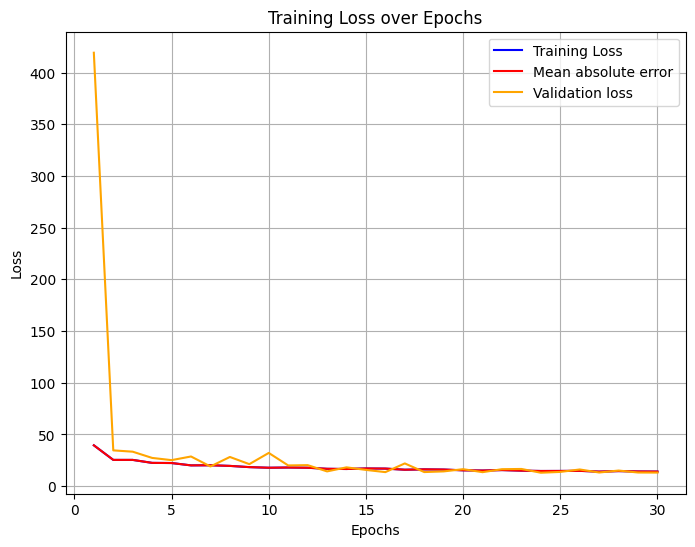

In [ ]:
# Extract loss values
loss_values3 = history3.history['loss']
mae_values3 = history3.history['mean_absolute_error']
validation_loss3 = history3.history['val_loss']
epochs = range(1, len(loss_values3) + 1)

# Plot loss curve
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values3, label='Training Loss', color='blue', linestyle='-')
plt.plot(epochs, mae_values3, label='Mean absolute error', color='red', linestyle='-')
plt.plot(epochs, validation_loss3, label='Validation loss', color='orange', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


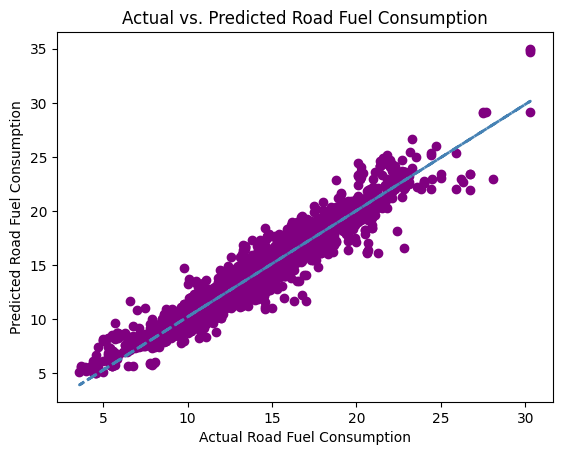

In [ ]:
# Scatter plot of the predictions vs label for NNs

# Road fuel efficiency
predictions1 = model1.predict(X_test)

a, b = np.polyfit(y1_test['fuel consumption'], predictions1, 1)
plt.scatter(y1_test['fuel consumption'], predictions1, color='purple')
plt.plot(y1_test['fuel consumption'], a*y1_test['fuel consumption'] + b, color='steelblue', linestyle='--', linewidth=2)  # Line of best fit
plt.xlabel("Actual Road Fuel Consumption")
plt.ylabel("Predicted Road Fuel Consumption")
plt.title("Actual vs. Predicted Road Fuel Consumption")
plt.show()

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


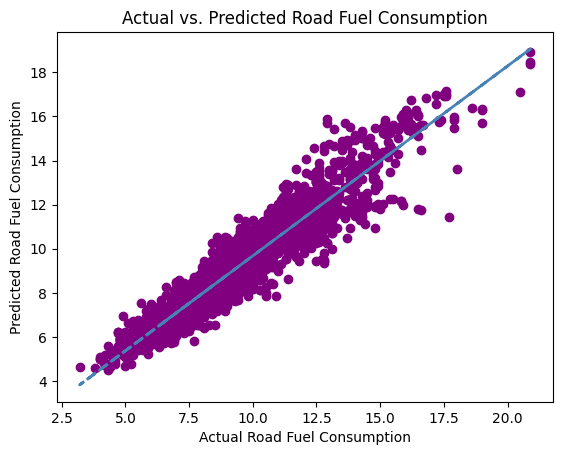

In [ ]:
# Highway Road efficiency
predictions2 = model2.predict(X_test)

a, b = np.polyfit(y2_test['hwy (l/100 km)'], predictions2, 1)
plt.scatter(y2_test['hwy (l/100 km)'], predictions2, color='purple')
plt.plot(y2_test['hwy (l/100 km)'], a*y2_test['hwy (l/100 km)'] + b, color='steelblue', linestyle='--', linewidth=2)  # Line of best fit
plt.xlabel("Actual Highway Fuel Consumption")
plt.ylabel("Predicted Highway Fuel Consumption")
plt.title("Actual vs. Predicted Highway Fuel Consumption")
plt.show()

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


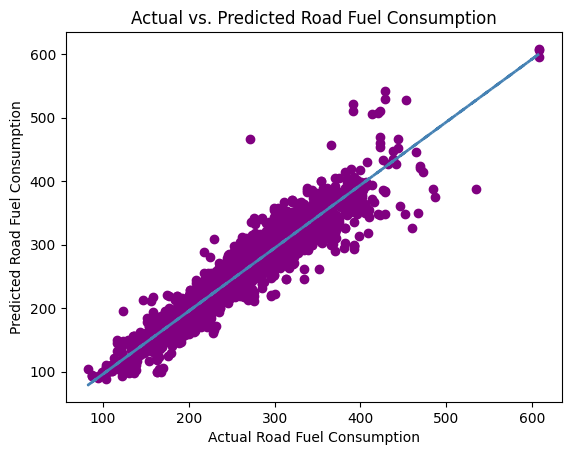

In [ ]:
# Emmisions
predictions3 = model3.predict(X_test)

a, b = np.polyfit(y3_test['emissions'], predictions3, 1)
plt.scatter(y3_test['emissions'], predictions3, color='purple')
plt.plot(y3_test['emissions'], a*y3_test['emissions'] + b, color='steelblue', linestyle='--', linewidth=2)  # Line of best fit
plt.xlabel("Actual Emmisions")
plt.ylabel("Predicted Emmisions")
plt.title("Actual vs. Predicted Emmsions")
plt.show()

In [ ]:
# Install needed streamlit and local tunnle imports
!pip install -q streamlit
!npm install localtunnel
!pip install googlemaps
!pip install openrouteservice
!pip install requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.4 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦
added 22 packages in 5s
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦Collecting googlemaps
  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40714 sha256=279559e01d12a8cf53345965a799b84165bff73574f6d7dd7cb5591e9062fda0
  Stored in directory: /root/.cache/pip/wheels/f1/09/77/3cc2f5659cbc62341b30f806aca2b25e6a26c351daa5b1f49a
Successfully built googlemaps


In [1]:
#@title App
%%writefile app.py

import streamlit as st
import pickle
import pandas as pd
from sklearn import preprocessing
import numpy as np
import os
import math
import gdown
import googlemaps
import openrouteservice
import requests
import json
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

API_KEY = st.secrets["API_KEY"]
ORS_API_KEY = st.secrets["ORS_API_KEY"]
ORS_client = openrouteservice.Client(key=ORS_API_KEY)
gmaps = googlemaps.Client(key=API_KEY)


# ------------------------- Functions -------------------------

# -- Utility
# Truncate float f to n decimal places without rounding
def truncate(f, n):
    if n == 0:
        return int(f)
    return math.floor(f * 10 ** n) / 10 ** n

# Converts meters_to_feet
def meters_to_feet(meters):
  feet = meters * 3.28084
  return feet

# Convert meters to miles
def meters_to_miles(meters):
    return meters / 1609.344


# Convert grams per kilometer to tonnes per mile
def gpkm_to_tpm(gpkm):
    grams_per_tonne = 1_000_000
    kilometers_per_mile = 1.60934
    return (gpkm / grams_per_tonne) * kilometers_per_mile

# --- Google maps
# Address to Coordinates (Geocoding)
def get_lat_lng(gmaps, address):
    try:
        geocode_result = gmaps.geocode(address)
        if geocode_result:
            lat = geocode_result[0]['geometry']['location']['lat']
            lng = geocode_result[0]['geometry']['location']['lng']
            return lat, lng
        else:
            print("Geocoding failed. Address not found.")
            return None
    except Exception as e:
        print(f"An error occurred during geocoding: {e}")
        return None

# Gets elevation of a coordinate in meters
def get_elevation(gmaps, lat, lng):
    try:
        elevation_result = gmaps.elevation((lat, lng))
        if elevation_result:
            elevation = elevation_result[0]['elevation']
            return elevation
        else:
            print("Elevation lookup failed.")
            return None
    except Exception as e:
        print("An error occurred during elevation lookup: {e}")
        return None

# -- Open route service maps api (after ors_client has been defined)
# Snaps coordinates to nearest to road
def snap_to_road(lat, lon):
    result = ORS_client.pelias_reverse((lon, lat))
    snapped = result['features'][0]['geometry']['coordinates']  # [lon, lat]
    return [snapped[1], snapped[0]]  # Return as [lat, lon]

# Snap coords to nearest city/town
def snap_to_city(latitude, longitude):
    # Initialize geolocator with user-agent
    geolocator = Nominatim(user_agent="city_snapper")

    # Get location from coordinates
    location = geolocator.reverse((latitude, longitude), language='en', exactly_one=True, timeout=10)

    if location:
        # Extract address details
        address = location.raw.get('address', {})

        # Try to get the most accurate city/town/village info
        city = address.get('city', None)
        town = address.get('town', None)
        village = address.get('village', None)
        suburb = address.get('suburb', None)

        # Use a hierarchy of fallback options
        if city:
            return location.latitude, location.longitude, city
        elif town:
            return location.latitude, location.longitude, town
        elif village:
            return location.latitude, location.longitude, village
        elif suburb:
            return location.latitude, location.longitude, suburb
        else:
            # Return general location if no city/town info available
            state = address.get('state', '')
            country = address.get('country', '')
            return location.latitude, location.longitude, f"{state}, {country}", 'spacer'
    else:
        return None

# Locate gas stations: returns [[[lon1, lat1], [lon2, lat2]], [{'name': 'Chevron'}, {'name': 'Shell'}]] up to 3 stations
def locate_gas(lat, lon, search_radius=2000, amount=10, ORS_API_KEY=ORS_API_KEY):
  body = {"request":"pois","geometry":{"geojson":{"type":"Point","coordinates":[lon, lat]},"buffer":search_radius},"filters":{"category_ids":[596]},"limit":amount}
  headers = {
      'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
      'Authorization': ORS_API_KEY,
      'Content-Type': 'application/json; charset=utf-8'
      }

  call = requests.post('https://api.openrouteservice.org/pois', json=body, headers=headers)
  response = json.loads(call.text)

  try:
    if response["features"]:
      return [[feature['geometry']['coordinates'] for feature in response["features"]],
              [feature['properties'].get('osm_tags', {}) for feature in response["features"]]]
    else:
      print("no features found")
  except:
    print(f"issue finding features: {response}")

# subdevides a route returns pandas df of points,
def subdivide_route(df, input, units="miles"):
  if units == "meters":
    interval = input
  elif units == "miles":
    interval = input * 1609.34

  # Initialize cumulative distance
  cumulative_distance = [0]
  for i in range(1, len(df)):
    dist = geodesic(
      (df.iloc[i-1]['lat'], df.iloc[i-1]['lon']),
      (df.iloc[i]['lat'], df.iloc[i]['lon'])
    ).meters
    cumulative_distance.append(cumulative_distance[-1] + dist)

  df['cumulative_dist'] = cumulative_distance

  # Get points at every interval meters
  output_points = []
  next_dist = 0

  for i in range(1, len(df)):
    if df.iloc[i]['cumulative_dist'] >= next_dist:
      output_points.append(df.iloc[i])
      next_dist += interval

  return pd.DataFrame(output_points).drop(columns=['cumulative_dist'])

# -- Model functions
# Label encode a column using a specified class order
def LabelEncode(input_df, column, order):
    le = preprocessing.LabelEncoder()
    le.fit(order)
    input_df[column] = le.transform(input_df[column])
    return input_df

# Download and load the trained model
def load_model():
    model_path = "Fuel Efficency estimator/RFR_model.pkl"
    if not os.path.exists(model_path):
        url = "https://drive.google.com/drive/folders/1efAbSVlSc8YIFFZ_9mAfZFyJsSRdD-jv"
        gdown.download_folder(url)
    with open(model_path, "rb") as f:
        return pickle.load(f)

# -- Main body dunctions
# UI for collecting user inputs
def get_input_data():
    st.title("Fuel Consumption and Road trip calculator")
    st.subheader("Input vehical specifications and click run")

    st.sidebar.title("Vehicle Spcifications")
    st.sidebar.write("Use Automobile-catalog to get unknown vehicle details")
    st.sidebar.link_button("Go to Automobile-catalog", "https://www.automobile-catalog.com/")

    year = st.sidebar.slider("Year", 2000, 2023)
    model = st.sidebar.radio("Drive Type", ["2WD", "4WD", "AWD"])
    size = st.sidebar.selectbox("Size", ['mini', 'sub', 'small', 'mid-size', 'standard', 'full-size', 'passenger', 'cargo', 'massive'])
    vehicle_class = st.sidebar.selectbox("Vehicle Class", [
        'compact', 'mid-size', 'station wagon', 'two-seater', 'full-size',
        'suv', 'van', 'pickup truck', 'minivan', 'special purpose vehicle'
    ])
    engine_size = st.sidebar.slider("Engine Size (L)", 0.9, 8.5, step=0.1)
    cylinders = st.sidebar.slider("Cylinder Count", 1, 16)
    fuel_type = st.sidebar.selectbox("Fuel Type", ['diesel', 'premium gasoline', 'gasoline', 'ethanol', 'natural gas'], index=2)
    make = st.sidebar.selectbox("Brand", [
        'acura', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge', 'ferrari',
        'ford', 'gmc', 'honda', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia', 'land rover',
        'lexus', 'lincoln', 'mazda', 'mercedes-benz', 'nissan', 'oldsmobile', 'plymouth', 'pontiac',
        'porsche', 'saab', 'saturn', 'subaru', 'suzuki', 'toyota', 'volkswagen', 'volvo', 'bentley',
        'rolls-royce', 'maserati', 'mini', 'mitsubishi', 'smart', 'hummer', 'aston martin', 'lamborghini',
        'bugatti', 'scion', 'fiat', 'ram', 'srt', 'alfa romeo', 'genesis'
    ])
    transmission = st.sidebar.radio("Transmission Type", ["Automatic", "Automatic Manual", "Automatic with select shift", "Continuously variable transmission", "Manual"])

    gears_disabled = (transmission == "AV")
    gears = st.sidebar.slider("Number of Gears", 1, 10, disabled=gears_disabled)

    # Remap Transission types from readible values to the ones used in preproccesing and prediction
    if transmission == "Automatic":
      transmission = "A"
    elif transmission == "Automatic Manual":
      transmission = "AM"
    elif transmission == "Automatic with select shift":
      transmission = "AS"
    elif transmission == "Continuously variable transmission":
      transmission = "AV"
    elif transmission == "Manual":
      transmission = "M"

    units = st.selectbox("Display Units", ['miles per gallon', 'liters per 100 kilometers'])
    decimal_places = st.slider("Decimal Places", 0, 10, value=4)

    data = {
        "year": year, "model": model, "size": size, "vehicle class": vehicle_class,
        "engine size": engine_size, "cylinders": cylinders, "fuel": fuel_type,
        "make": make, "transmission": transmission, "gears": gears
    }

    return pd.DataFrame(data, index=[0]), units, decimal_places

# Encode categorical variables using label encoding and one-hot encoding
def preprocess_input(input_df):
    input_df = LabelEncode(input_df, 'model', ['2WD', 'AWD', '4WD'])
    input_df = LabelEncode(input_df, "size", ['mini', 'sub', 'small', 'mid-size', 'standard', 'full-size', 'passenger', 'cargo', 'massive'])
    input_df = LabelEncode(input_df, "fuel", ['diesel', 'premium gasoline', 'gasoline', 'ethanol', 'natural gas'])

    transmission_cats = [f"transmission type_{t}" for t in ["A", "AM", "AV", "M", "AS"]]
    make_cats = [f"make_{m}" for m in [
        'acura', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge', 'ferrari',
        'ford', 'gmc', 'honda', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia', 'land rover',
        'lexus', 'lincoln', 'mazda', 'mercedes-benz', 'nissan', 'oldsmobile', 'plymouth', 'pontiac',
        'porsche', 'saab', 'saturn', 'subaru', 'suzuki', 'toyota', 'volkswagen', 'volvo', 'bentley',
        'rolls-royce', 'maserati', 'mini', 'mitsubishi', 'smart', 'hummer', 'aston martin', 'lamborghini',
        'bugatti', 'scion', 'fiat', 'ram', 'srt', 'alfa romeo', 'genesis'
    ]]

    vehicle_cats = [f"vehicle_{v}" for v in [
        'compact', 'mid-size', 'station wagon', 'two-seater', 'full-size',
        'suv', 'van', 'pickup truck', 'minivan', 'special purpose vehicle'
    ]]

    onehot_T = pd.get_dummies(input_df["transmission"].astype(pd.CategoricalDtype(categories=transmission_cats)))
    onehot_M = pd.get_dummies(input_df["make"].astype(pd.CategoricalDtype(categories=make_cats)))
    onehot_V = pd.get_dummies(input_df["vehicle class"].astype(pd.CategoricalDtype(categories=vehicle_cats)))

    input_df.drop(["transmission", "make", "vehicle class"], axis=1, inplace=True)
    input_df = pd.concat([input_df, onehot_T, onehot_M, onehot_V], axis=1)

    final_columns = ['year', 'model', 'size', 'engine size', 'cylinders', 'gears', 'fuel'] + make_cats + vehicle_cats + transmission_cats
    return input_df[final_columns]

# ------------------------- App Logic -------------------------

model = load_model()
input_df, units, decimal_places = get_input_data()
run = st.button("Run", use_container_width=True)

# Initialize session state variables
st.session_state.setdefault('prediction', None)
st.session_state.setdefault('ran', False)

if run:
    st.session_state.ran = True
    with st.spinner("Running prediction..."):
        processed = preprocess_input(input_df)
        input_values = [processed.loc[0].values.tolist()]
        prediction = model.predict(input_values)
        # convert to mpg by default
        prediction[0][0] = 235.215 / prediction[0][0]
        prediction[0][1] = 235.215 / prediction[0][1]
        # If l/100km convert back
        if units == 'liters per 100 kilometers':
          prediction[0][0] = 235.215 / prediction[0][0]
          prediction[0][1] = 235.215 / prediction[0][1]
        st.session_state.prediction = prediction

# ------------------------- Output Display -------------------------

if st.session_state.ran:
    titles = ["City Fuel Consumption", "Highway Fuel Consumption", "Emissions (g/km)"]
    preds = [truncate(x, decimal_places) for x in st.session_state.prediction[0]]
    st.table(pd.DataFrame([preds], columns=titles))

    gas_price = st.number_input("Estimated Gas Price", value=None)
    tank_size = st.number_input("Gas Tank Size (gallons)", value=None)

    mileage = None

    # Use maps api: disply features
    if st.toggle("Use Map API"):
      highway_ratio = 0.75

      # Start and end inputs
      start = st.text_input("Start point")
      end = st.text_input("End point")

      # Route display subdivision
      subdivision = st.slider("tenths of a mile between route markers", 1, 250)
      subdivision /= 10

      if start and end:
        start_coords = get_lat_lng(gmaps, start)
        end_coords = get_lat_lng(gmaps, end)

        # If google maps returns coords
        if start_coords and end_coords:
          start_lat, start_lon = start_coords
          end_lat, end_lon = end_coords

          # Button for finding gas stations
          if tank_size:
            gas_subdivision = st.slider("frequency of displayed gas stops, in percent of tank", 0, 100, value=25) * 0.01
            gas_locator = st.button("Locate gas stations along route")
          else:
            gas_locator = False
            gas_subdivision = 0

          # Get route
          try:
            route = ORS_client.directions(
                coordinates=[[start_lon, start_lat], [end_lon, end_lat]],
                profile='driving-car',
                format='geojson'
            )
          # Check if route is valid
          except:
            st.title(":warning: No route found :warning:")
            route = None

          if route:
            # Decode the polyline from geometry (or use GeoJSON coordinates directly)
            geometry = route['features'][0]['geometry']['coordinates']

            # Convert geometry to a DataFrame
            route_points = pd.DataFrame(geometry, columns=['lon', 'lat'])

            # Locate gas stations along route
            if gas_locator:
              with st.status("Locating gas stations...."):
                # subdivide route so that you have 80% of gas tank left between waypoints if filling up at gas stations
                gas_waypoints = subdivide_route(route_points, (st.session_state.prediction[0][1] * tank_size) * gas_subdivision)

                gas_stations = []
                # iterate through gas waypoints and locate gas stations
                for index, row in gas_waypoints.iterrows():
                  stations = locate_gas(row['lat'], row['lon'])
                  # if it found stations
                  if stations:
                    print(f"fully formatted: {stations}")
                    gas_stations.append(stations)
                  else:
                    # attempt to snap it to a city
                    snapped_coords = snap_to_city(row['lat'], row['lon'])
                    # If it succesfully snapped coords to a city
                    if len(snapped_coords) == 3:
                      print(f"snapped to city: {snapped_coords}")
                      stations = locate_gas(snapped_coords[0], snapped_coords[1])
                    # didn't find city and snapped to area instead
                    elif len(snapped_coords) == 4:
                      print("no city near")
                    # something wrong happened
                    else:
                      print("Error snapping to town")
                    if stations:
                      print(f"fully formatted after snapped: {stations}")
                      gas_stations.append(stations)

                print(f"searching for gas stations along {len(gas_stations)} points")

                gas_station_points = []

                for station_set in gas_stations:
                  for station_coords in station_set[0]:
                    gas_station_points.append([station_coords[1], station_coords[0]])

                  for station_info in station_set[1]:
                    st.write(station_info)


                # Make pandas dataframe out of points and add color and size
                gas_station_points = pd.DataFrame(gas_station_points, columns=['lat', 'lon'])
                gas_station_points['color'] = '#AAFF0080'
                gas_station_points['size'] = 50

            # Make dataframe of route display points and add color and size
            route_display_points = subdivide_route(route_points, subdivision)
            route_display_points['color'] = '#FF0000'
            route_display_points['size'] = 0.1

            # Make end and start points for route and add color and size
            end_points = pd.DataFrame({"lat": [start_lat, end_lat], "lon": [start_lon, end_lon]})
            end_points['color'] = '#0000FF80'
            end_points['size'] = 75

            # Combine route display and end points into one dataframe
            if gas_locator:
              final_points = pd.concat([route_display_points, end_points, gas_station_points], ignore_index=True)
            else:
              final_points = pd.concat([route_display_points, end_points], ignore_index=True)

            # Display map
            st.map(final_points, color='color', size='size')

            # Get elevation from start and end coords
            start_elevation = get_elevation(gmaps, start_lat, start_lon)
            end_elevation = get_elevation(gmaps, end_lat, end_lon)
            avg_elevation = (meters_to_feet(start_elevation)  + meters_to_feet(end_elevation)) / 2

            # Elevation checks and warnings
            if avg_elevation >= 1750:
              st.write(f":warning: *Warning: The elevation you are driving at is {int(avg_elevation)} ft and at this elevation engine power and effciency will be reduced by about {int((avg_elevation / 1000) * 3)}%* :warning:")
            if (end_elevation - start_elevation) >= 500:
              st.write(f":warning: *Warning: Net elevation change ascends {int(meters_to_feet(end_elevation - start_elevation))} ft which may reduce fuel efficiency* :warning:")
            if (end_elevation - start_elevation) <= -500:
              st.write(f"*Net elevation change descends {int(meters_to_feet(end_elevation - start_elevation))} ft which may increase fuel efficiency*")

            # Link to google maps route
            st.link_button("Go to Google maps route", f"https://www.google.com/maps/dir/?api=1&origin={start_lat},{start_lon}&destination={end_lat},{end_lon}&travelmode=driving")

            # Auto populate milaege from route
            mileage = meters_to_miles(route['features'][0]['properties']['summary']['distance'])
            st.write(f"Mileage: {truncate(mileage, 1)}")

            # Display elevation stats
            st.write("Elevation Change (m): " + str(truncate(end_elevation - start_elevation, 2)))
            st.write("Average Elevation (m): " + str(truncate(avg_elevation, 2)))
    else:
      # Request mileage from the user
      mileage = st.number_input("Trip Mileage Estimate", value=None)
      highway_ratio = st.slider("Highway Driving %", 0, 100, value=75) / 100

    # Calculate stats from mileage etc
    if mileage:
        h_miles = highway_ratio * mileage
        r_miles = (1 - highway_ratio) * mileage
    if mileage and gas_price:
        total_cost = truncate(((h_miles / st.session_state.prediction[0][1]) + (r_miles / st.session_state.prediction[0][0])) * gas_price, 2)
    if mileage and tank_size:
        tank_refills = int(((h_miles / st.session_state.prediction[0][1]) + (r_miles / st.session_state.prediction[0][0])) / (tank_size * 0.75))

    if mileage and gas_price and tank_size:
        st.table(pd.DataFrame([[total_cost, tank_refills]], columns=["Trip Cost", "Tank Refills"]))

    # Emmisions estimate
    if mileage:
      emissions_tpm = gpkm_to_tpm(st.session_state.prediction[0][2])
      st.subheader(f"Total Emissions (Tonnes): {truncate(emissions_tpm * mileage, 10)}")

      # Display donation stuff
      st.write(f"Donate ${truncate((emissions_tpm * mileage) * 18.68, 2)}, to offset carbon emmisions")

      st.link_button("Donate Here", "https://www.cooleffect.org/store/donate")

      st.subheader("What is this?")
      st.write("Cooleffect.org takes carbon offset donations and uses them to fund emmision reducing projects around the world!")
      st.write("Learn more here:")
      st.page_link("https://www.cooleffect.org/about-us", label="CoolEffect.org", icon="🌎")


Writing app.py


In [ ]:
import os
from google.colab import userdata


# Create the .streamlit directory
os.makedirs("/root/.streamlit", exist_ok=True)

# Write the secrets.toml file
try:
  secrets = f"""
  API_KEY = {userdata.get('API_KEY')}
  ORS_API_KEY = {userdata.get('ORS_API_KEY')}
  """
except:
  raise ImportError("API KEYs not present, if you just want to use the app go to https://fuel-estimator.streamlit.app/ \n Otherwise you will need to provide your own API KEYs via the colab secrets panel")

with open("/root/.streamlit/secrets.toml", "w") as f:
    f.write(secrets)

print("secrets.toml file created at /root/.streamlit/secrets.toml")

secrets.toml file created at /root/.streamlit/secrets.toml


In [ ]:
# Start streamlit and local tunnel
!wget -q -O - ipv4.icanhazip.com
!streamlit run app.py & npx localtunnel --port 8501

34.169.90.255
⠙

your url is: https://bright-clubs-hunt.loca.lt

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.169.90.255:8501

Retrieving folder contents
Processing file 1KO8rKBTCdCzwIo_XHW1wAvs2HxOlPjLl NN_model1.pkl
Processing file 1q2ZYwxDsb59Cijt_rtfna_qvrLjJ4wfk NN_model2.pkl
Processing file 11KCbOr-8RlWJ1ykByMdM_oFBt8QWoRH- NN_model3.pkl
Processing file 18CjNTBC7qt3NQvvHmarXtycDKdp1sK-V RFR_model.pkl
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1KO8rKBTCdCzwIo_XHW1wAvs2HxOlPjLl
From (redirected): https://drive.google.com/uc?id=1KO8rKBTCdCzwIo_XHW1wAvs2HxOlPjLl&confirm=t&uuid=9dab3b84-aca1-48c2-82ae-bcf44416ffcf
To: /content/Fuel Efficency estimator/NN_model1.pkl
100% 268M/268M [00:01<00:00, 202MB/s]
Downloading...
From (original): https://drive.googl